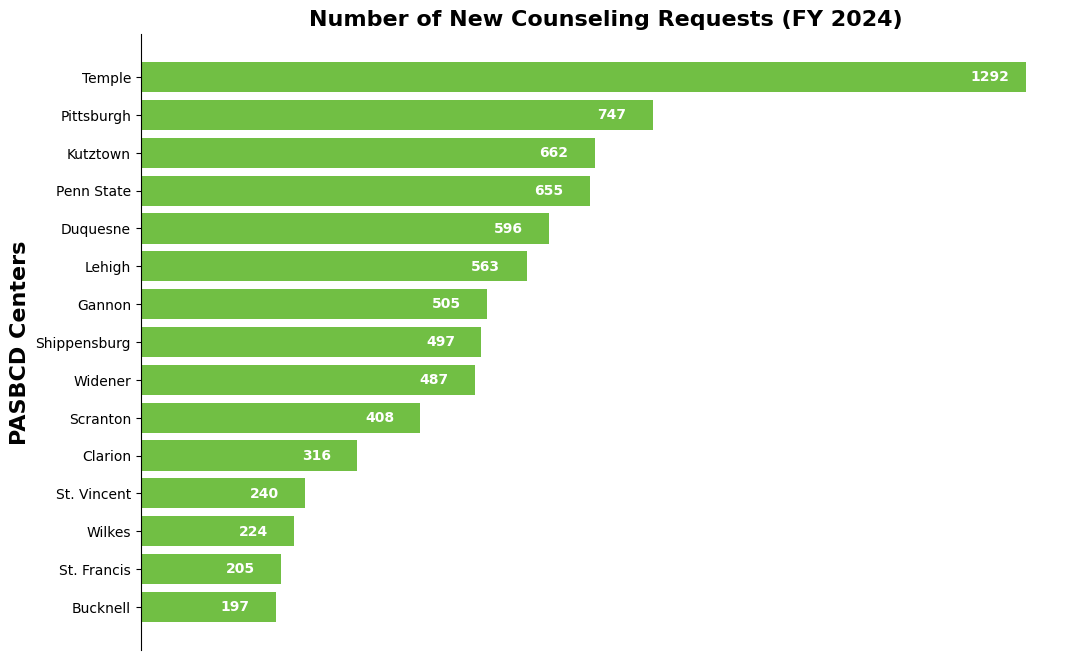

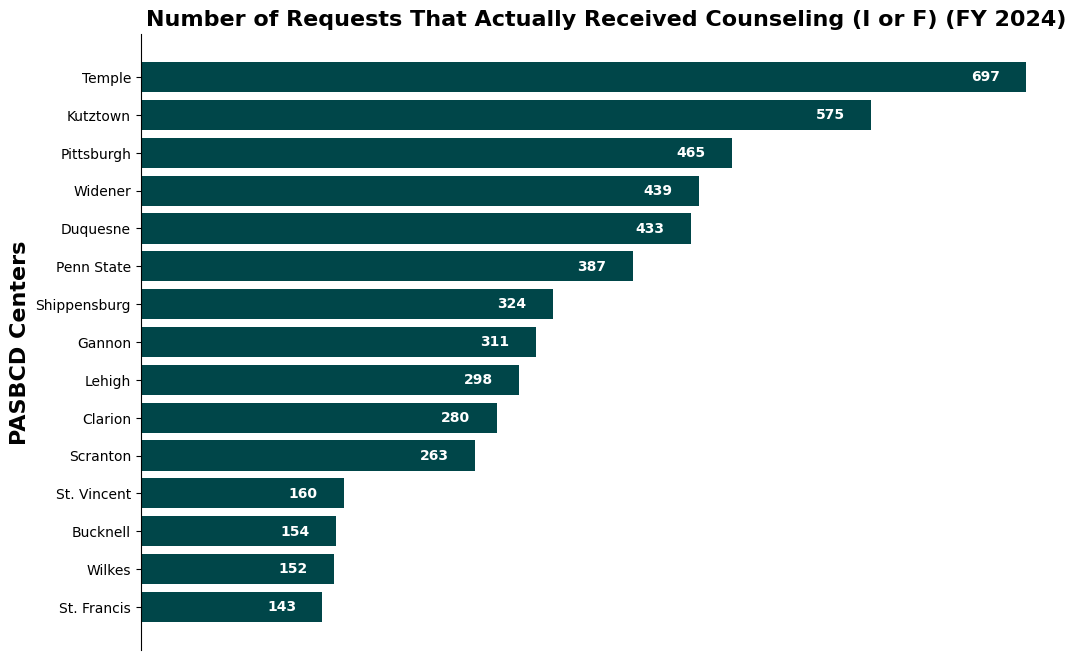

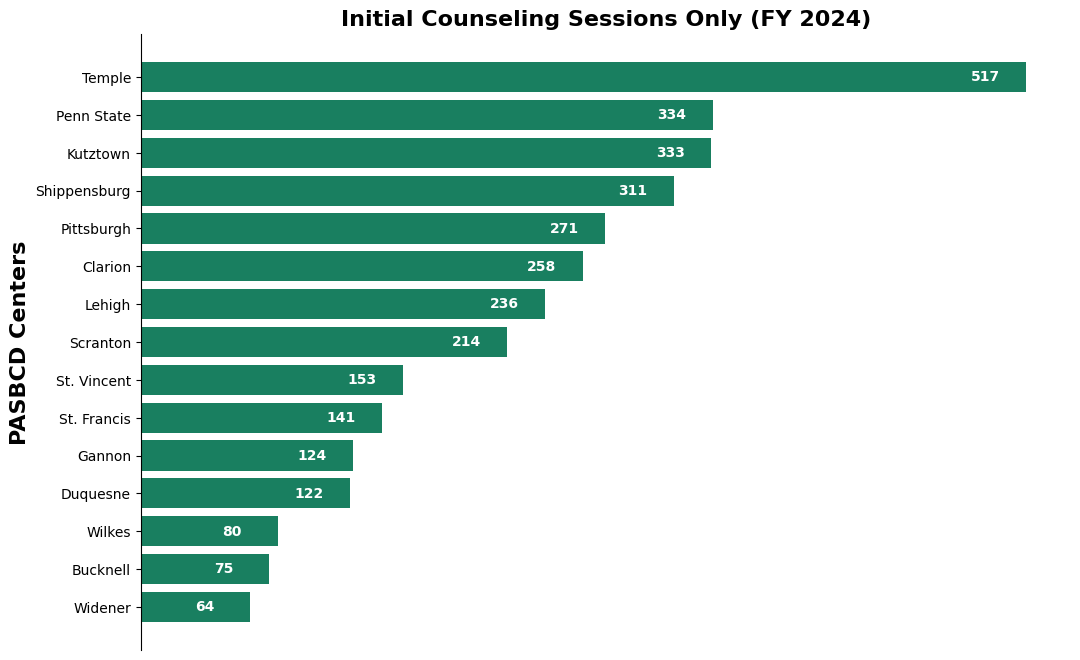

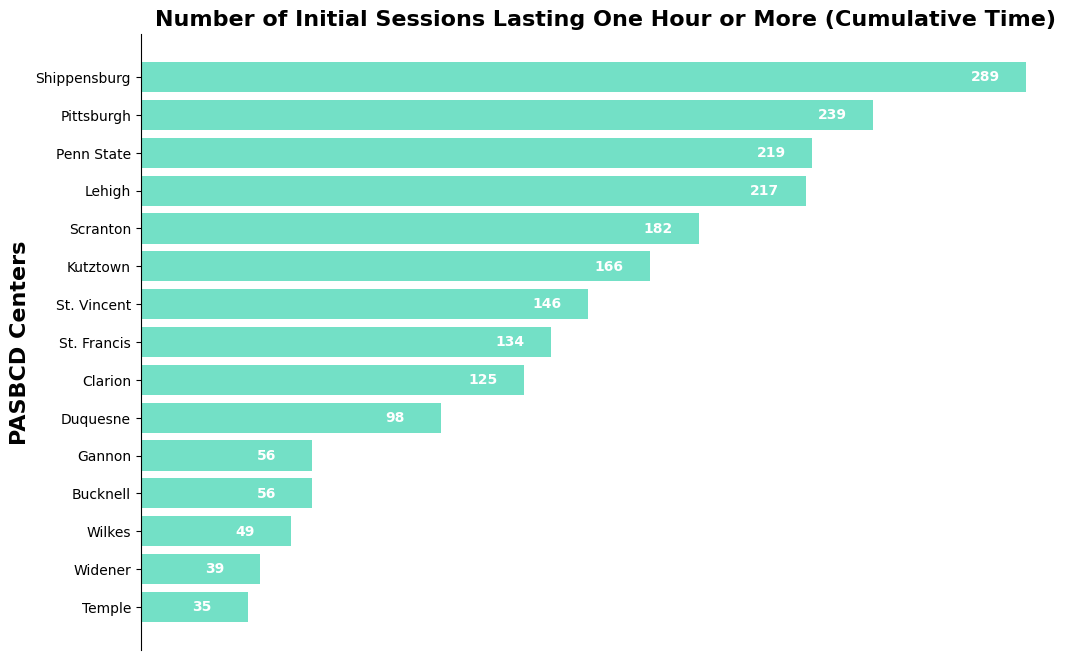

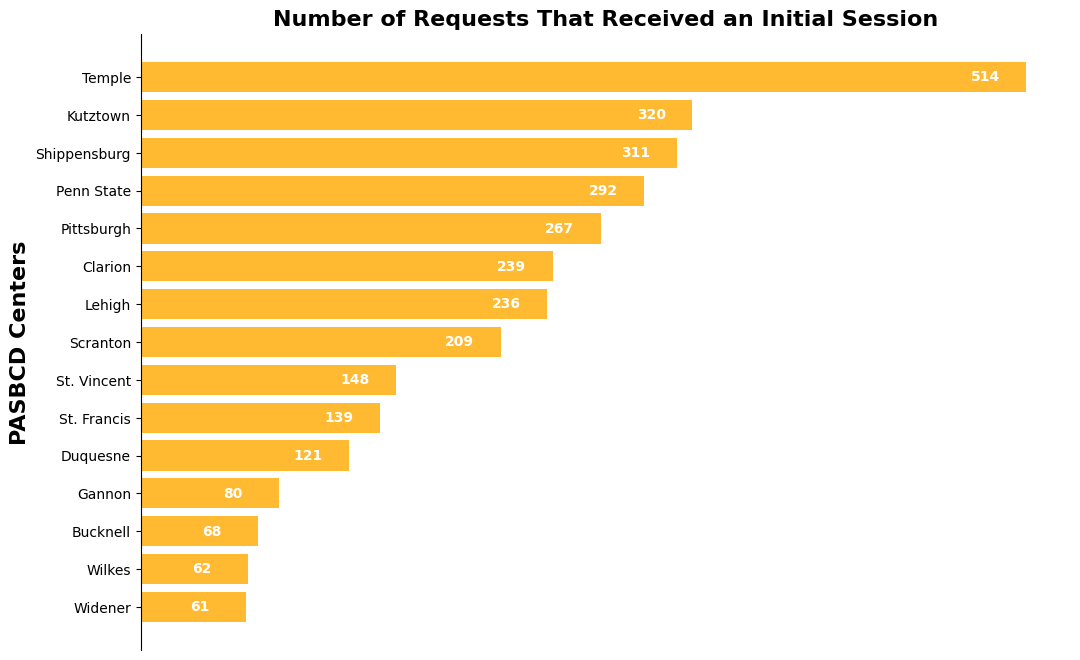

,Center,Number of eCenter Counseling Requests,Initial Sessions ≥ 30 Minutes,eCenter Conseling Requests Conversion Rate
0,Bucknell,197,68,34.5%
1,Clarion,316,239,75.6%
2,Duquesne,596,121,20.3%
3,Gannon,505,80,15.8%
4,Kutztown,662,320,48.3%
5,Lehigh,563,236,41.9%
6,Penn State,655,292,44.6%
7,Pittsburgh,747,267,35.7%
8,Scranton,408,209,51.2%
9,Shippensburg,497,311,62.6%


In [14]:
# Author: Martin De La Cruz

import pandas as pd
import matplotlib.pyplot as plt
import json

filenames_graphnames = {
    'req_counseling_FY2024.csv': ('Number of New Counseling Requests (FY 2024)', '#71bf44'),
    'conversion_rate_FY2024.csv': ('Number of Requests That Actually Received Counseling (I or F) (FY 2024)', '#004649'),
    'conversion_initial_only.csv': ('Initial Counseling Sessions Only (FY 2024)', '#197f60'),
    'conversion_initial_hour_or_more.csv': ('Number of Initial Sessions Lasting One Hour or More (Cumulative Time)', '#73e0c6'),
    'at_least_30_minutes.csv': ('Number of Requests That Received an Initial Session', '#ffba31')
}


class ConfigLoader:
    @staticmethod
    def load_json(file_path):
        """
        Loads a JSON file and returns its content.
        
        Args:
            file_path (str): The path to the JSON file.
        
        Returns:
            dict: The content of the JSON file as a Python dictionary.
        """
        with open(file_path, 'r') as file:
            return json.load(file)

class FileManager:
    def __init__(self, filenames):
         """
        Initializes the FileManager with the given filenames, reads the CSV files, and loads center mappings.

        Args:
            filenames (dict): A dictionary of filenames and their corresponding graph names.
        """
        self.filenames = filenames_graphnames.keys()
        self.dataframes = self.read_all_files()
        self.center_mappings = ConfigLoader.load_json('centers_mapping.json')

    def read_all_files(self):
        """
        Reads all CSV files from the provided filenames and cleans numeric columns by converting them to numeric.

        Returns:
            dict: A dictionary of DataFrames, one for each CSV file.
        """
        dfs = {name: pd.read_csv(name) for name in self.filenames}
        for df in dfs.values():
            self.convert_to_numeric(df)
        return dfs

    @staticmethod
    def convert_to_numeric(df):
        """
        Converts columns containing 'Total' in their name from strings to numeric values.
        
        Args:
            df (pd.DataFrame): The DataFrame to be processed.
        """
    
        words = ['Total', 'total', 'number of', 'Number of']
        
        for col in df.columns:
            if any(word in col for word in words) and df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

    
    def reassign_centers(self, center):
        """
        Reassigns center names based on the mapping defined in the 'centers_mapping.json' file.

        Args:
            center (str): The original center name.

        Returns:
            str: The reassigned center name based on the mapping.
        """
        for key, values in self.center_mappings.items():
            if any(value in center for value in values):
                return key
        return center


class DataAggregation:
    @staticmethod
    def aggregate_and_calculate(df, groupby_col, aggr_col, transform_func=None, drop_duplicates=False, agg_func=None):
        """
        Aggregates the counts of a specified column after applying an optional transformation function.

        Args:
            df (pd.DataFrame): The DataFrame to aggregate.
            groupby_col (str): The column name to group by.
            aggr_col (str): The column to aggregate.
            transform_func (function, optional): A function to transform the 'groupby_col' values. Default is None.
            drop_duplicates (bool, optional): Whether to drop duplicates in the DataFrame. Default is False.
            agg_func (str, optional): The aggregation function to apply (e.g., 'count', 'sum'). Default is 'count'.
        
        Returns:
            pd.DataFrame: The aggregated DataFrame.
        """
        
        if drop_duplicates:
            df = df.drop_duplicates()

        if transform_func:
            df.loc[:, groupby_col] = df[groupby_col].apply(transform_func)

        if not agg_func:
            agg_func ='count'

        result = df.groupby(groupby_col)[aggr_col].agg(agg_func).reset_index()
        return result

class GraphData:
    @staticmethod
    def graph_horizontal_barchart(df, x, y, title, color):
        """
        Generates and saves a horizontal bar chart from the provided DataFrame.
        
        Args:
            df (pd.DataFrame): The DataFrame containing the data to plot.
            x (str): The column name for the x-axis.
            y (str): The column name for the y-axis.
            title (str): The title of the graph.
            color (str): The color to use for the bars in the chart.
        
        Returns:
            plt.Axes: The matplotlib Axes object for the plot.
        """
        
        df.sort_values(y, inplace=True)
        plt.figure(figsize=(12, 8))


        bars = plt.barh(df[x], df[y], color=color)
        ax = plt.gca()  # Get the current Axes instance
        for spine in ['right', 'top', 'bottom']:
            ax.spines[spine].set_visible(False)
        
        ax.xaxis.set_visible(False)
        ax.bar_label(bars, padding=-40, color='white', fontweight='bold')
        plt.xlabel('Number of Requests')
        plt.ylabel('PASBCD ' + x + 's', fontweight='bold', fontsize=16)
        plt.title(title, fontweight='bold', fontsize=16)
        plt.savefig(title + '.png')

        return plt.show()


class ReportGenerator:
    def __init__(self, filenames):
        """
        Initializes the ReportGenerator with the given filenames and sets up the necessary components.
        
        Args:
            filenames (dict): A dictionary of filenames and their corresponding graph names.
        """
        self.file_manager = FileManager(filenames)
        self.data_aggregation = DataAggregation()
        self.graph_data = GraphData()

    def report_county(self, file):
        """
        Generates a report by county for the specified file and saves it as a CSV.

        Args:
            file (str): The filename to generate the report from.
        
        Returns:
            pd.DataFrame: The aggregated DataFrame for the county report.
        """

        df = self.file_manager.dataframes[file]
        rfc = self.data_aggregation.aggregate_and_calculate(
            df, groupby_col='Physical Address County', aggr_col='Client', drop_duplicates='Client', agg_func='count')

        if 'req_counseling_FY2024' in file:
            rfc.to_csv('Number_of_eCenter_Counseling_Requests_in_Fiscal_Year_2024_By_County.csv')

        if 'conversion_rate_FY2024' in file:
            rfc.to_csv('Counseling_Requests_in_Fiscal_Year_2024_conversion_with_Initial_or_Follow-Up.csv')

        if 'conversion_initial_only' in file:
            rfc.to_csv('Counseling_Requests_in_Fiscal_Year_2024_conversion_with_Initial_Only.csv')

        if 'conversion_initial_hour_or_more' in file:
            rfc.to_csv('Counseling_Requests_in_Fiscal_Year_2024_conversion_with_Initial_Only_OneHour_or_More.csv')

        return rfc


    def report_center(self, file):
        """
        Generates a report by center for the specified file and returns the aggregated data.

        Args:
            file (str): The filename to generate the report from.
        
        Returns:
            pd.DataFrame: The aggregated DataFrame for the center report.
        """

        df = self.file_manager.dataframes[file]
        rfc = self.data_aggregation.aggregate_and_calculate(
            df, groupby_col='Center', aggr_col='Client', transform_func=self.file_manager.reassign_centers, drop_duplicates='Client', agg_func='count')

        return rfc

    def report_center_omit_some(self, file, rename_col):
        """
        Generates a report by center for the specified file and omits certain center values.

        Args:
            file (str): The filename to generate the report from.
            rename_col (str): The new name for the 'Client' column in the resulting DataFrame.
        
        Returns:
            pd.DataFrame: The filtered and aggregated DataFrame for the center report.
        """

        df = self.file_manager.dataframes[file]
        rfc = self.data_aggregation.aggregate_and_calculate(
            df, groupby_col='Center', aggr_col='Client', transform_func=self.file_manager.reassign_centers, drop_duplicates='Client', agg_func='count')

        rfc = rfc[
        (rfc['Center'] != 'State Small Business Credit Initiative (SSBCI)') & # not include
        (rfc['Center'] != 'AA - Stakeholders/Partners') &
        (rfc['Center'] != 'Lead Office') & 
        (rfc['Center'] != 'Wharton SBDC') & #
        (rfc['Center'] != 'EMAP')
        ]

        rfc.rename(columns={'Client':rename_col}, inplace=True)

        
        return rfc

    @staticmethod
    def calculate_percentage(df1, df2, rename_col, df1_col=None,df2_col=None, percent='eCenter Conseling Requests Conversion Rate'):
        """
        Calculates the percentage of conversion between two DataFrames based on a specified column.

        Args:
            df1 (pd.DataFrame): The first DataFrame containing the baseline data.
            df2 (pd.DataFrame): The second DataFrame containing the converted
        """
        df = pd.merge(df1,df2,how='inner', on=rename_col)
    
        df[percent] = df[df2_col] / df[df1_col] * 100
        df[percent] = df[percent].apply(lambda x: f'{x:.1f}%')
    

        return df


objects = ReportGenerator(filenames)


for file, (title, color) in filenames_graphnames.items():
    df = objects.report_center_omit_some(file, title)
    objects.graph_data.graph_horizontal_barchart(df, 'Center', title, title, color)


df1 = objects.report_center_omit_some('req_counseling_FY2024.csv', 'Number of eCenter Counseling Requests')
df2 = objects.report_center_omit_some('at_least_30_minutes.csv', 'Initial Sessions ≥ 30 Minutes')

x = ReportGenerator.calculate_percentage(df1, df2, 'Center', 'Number of eCenter Counseling Requests', 'Initial Sessions ≥ 30 Minutes')
x